In [1]:
!../py/modules/pkginstall.sh myst-nb

Installed myst-nb 1.1.2.


# Data retrieval

Both IOER and NFDI provide standardized ways to access data. NFDI provides a [RESTful Application Programming Interface (API)](https://techdocs.gbif.org/en/openapi/), the IOER monitor allows to query spatial raster data as a [Web Coverage Service (WCS)](https://de.wikipedia.org/wiki/Web_Coverage_Service).

:::{tip}
Finding your way through the Python spatial package software ecosystem can be daunting. Before getting started, it is best to take some time to review the available packages and weigh the alternatives before jumping into writing code.
:::

For RESTful APIs, the go-to package in Python is the `requests' library. We have already used this library in the [previous section](201_example_introduction). For WCS queries in Python, it is necessary to check the available alternatives. For example, a quick search with one of the major web search engines may lead us to [GemGIS](https://gemgis.readthedocs.io/). This package provides a routine to query WCS, which we can find out by looking at its [docs](https://gemgis.readthedocs.io/en/stable/getting_started/tutorial/21_working_with_web_coverage_services.html). However, on a close look, we see that _GemGIS_ uses [OWSLib](https://github.com/geopython/OWSLib) under the hood. With OWSLib we can query the WCS directly in our Jupyter notebook. A web search can show some examples like the [ISIRC SoilGrids notebooks](https://www.isric.org/web-coverage-services-wcs) or the [NASAMAAP documentation](https://docs.maap-project.org/en/stable/technical_tutorials/access/edav_wcs_data.html).

# NFDI Occurrence Query

```{figure} https://techdocs.gbif.org/en/data-processing/_images/data-processing.png
:name: gbif-graphic
:figclass: fig-no-shadow

GBIF Data Processing Documentation (https://techdocs.gbif.org/en/data-processing/).
```

```{admonition} Preview results on a map first (land.gbif.de) 
:class: dropdown, tip

An interface to the GBIF API is available at [https://land.gbif.de/occurrence/search/](https://land.gbif.de/occurrence/search/).

- You can preview the results on a map using the search key [https://land.gbif.de/occurrence/search/?taxonKey=5231190&view=MAP](https://land.gbif.de/occurrence/search/?taxonKey=5231190&view=MAP).  
- The `taxonKey=5231190` can be found in [the search result in the previous section](content:references:nub-id).
- You can also search for `English Sparrow` and this `taxonKey` ID will be added automatically.  

```


The RESTful service API from GBIF/NFDI is available at [techdocs.gbif.org](https://techdocs.gbif.org/). If you find API documentation like this, which is automatically build using [Swagger](https://swagger.io/), you are a big step further! Swagger based interactive API documentations allow to _test_ API endpoints before implementing any code.

You can find detailed information for the occurrence query _endpoint_ [in the docs](https://techdocs.gbif.org/en/openapi/v1/occurrence#/Searching%20occurrences/searchOccurrence).

## Test query for a few observations

Let's query the API directly from Jupyter.

First, specify the basic query parameters:

In [2]:
taxon_id = "420" # The English Sparrow (replace with your own chosen ID!)
taxon_key = "5231190" # Taxon Key for Sparrows
continent = "europe"
limit = 10
query_url = f"https://api.gbif.org/v1/occurrence/search" \
    f"?taxon_id={taxon_id}&limit={limit}&continent={continent}"

In [3]:
import requests

response = requests.get(
    url=query_url)

Check the `status_code`. `200` Means: _Ok_

```{admonition} Some more HTML status codes that may be encountered
:class: dropdown, hint

| HTML Status Code | Message/Meaning       |
| ---------------- | --------------------- |
| 200              | OK                    |
| 400              | Bad request           |
| 403              | Forbidden             |
| 429              | Too Many Requests     |
| 500              | Internal Server Error |
| 503              | Service Unavailable   |
| 504              | Gateway Timeout       |

```

In [4]:
response.status_code

200

To check the returned data, access the `.text` field and use the `json` library to parse it.

In [5]:
json_text = response.text

In [6]:
import json
json_data = json.loads(json_text)
print(json.dumps(json_data, indent=2)[0:1000])

{
  "offset": 0,
  "limit": 10,
  "endOfRecords": false,
  "count": 44,
  "results": [
    {
      "key": 3391177530,
      "datasetKey": "0f7c7942-c5d2-435e-afba-97df549dbc19",
      "publishingOrgKey": "37560003-ae75-43c3-95aa-48c98797aa2a",
      "installationKey": "06d75b22-fc7a-42ff-a14f-65a25cd0f3ab",
      "hostingOrganizationKey": "cdcc4ce1-7f6e-4ed2-b47c-eb451925b038",
      "publishingCountry": "PT",
      "protocol": "EML",
      "lastCrawled": "2023-11-21T13:29:26.741+00:00",
      "lastParsed": "2024-01-24T16:01:50.200+00:00",
      "crawlId": 102,
      "extensions": {},
      "basisOfRecord": "HUMAN_OBSERVATION",
      "occurrenceStatus": "PRESENT",
      "taxonKey": 1833626,
      "kingdomKey": 1,
      "phylumKey": 54,
      "classKey": 216,
      "orderKey": 797,
      "familyKey": 9689,
      "genusKey": 1833623,
      "speciesKey": 1833626,
      "acceptedTaxonKey": 1833626,
      "scientificName": "Oecophora bractella Linnaeus, 1758",
      "acceptedScientificName"

We can also apply a validity check by comparing how many results have been returned. Since we specified a limit of `10` in our original query, we expect that `10` observastions of occurence are also returned.

In [7]:
len(json_data["results"])

10

Let's have a look at the first element. We can see that there are two entries used as a spatial reference:
```
'decimalLatitude': 41.99907,
'decimalLongitude': -8.17893,
```

In [8]:
json_data["results"][0]

{'key': 3391177530,
 'datasetKey': '0f7c7942-c5d2-435e-afba-97df549dbc19',
 'publishingOrgKey': '37560003-ae75-43c3-95aa-48c98797aa2a',
 'installationKey': '06d75b22-fc7a-42ff-a14f-65a25cd0f3ab',
 'hostingOrganizationKey': 'cdcc4ce1-7f6e-4ed2-b47c-eb451925b038',
 'publishingCountry': 'PT',
 'protocol': 'EML',
 'lastCrawled': '2023-11-21T13:29:26.741+00:00',
 'lastParsed': '2024-01-24T16:01:50.200+00:00',
 'crawlId': 102,
 'extensions': {},
 'basisOfRecord': 'HUMAN_OBSERVATION',
 'occurrenceStatus': 'PRESENT',
 'taxonKey': 1833626,
 'kingdomKey': 1,
 'phylumKey': 54,
 'classKey': 216,
 'orderKey': 797,
 'familyKey': 9689,
 'genusKey': 1833623,
 'speciesKey': 1833626,
 'acceptedTaxonKey': 1833626,
 'scientificName': 'Oecophora bractella Linnaeus, 1758',
 'acceptedScientificName': 'Oecophora bractella Linnaeus, 1758',
 'kingdom': 'Animalia',
 'phylum': 'Arthropoda',
 'order': 'Lepidoptera',
 'family': 'Oecophoridae',
 'genus': 'Oecophora',
 'species': 'Oecophora bractella',
 'genericName'

We want to create a map to preview the 10 results. For this, we first need to extract the coordinates from all results. We can use a [list comprehension](https://docs.python.org/3.8/tutorial/datastructures.html#list-comprehensions).

In [9]:
coordinates = [
    (obs['decimalLongitude'], obs['decimalLatitude'])
    for obs in json_data["results"]]
coordinates

[(-8.17893, 41.99907),
 (-1.3878, 45.95779),
 (-4.3653, 48.31355),
 (-4.3653, 48.31355),
 (-4.3653, 48.31355),
 (-4.3653, 48.31355),
 (1.18253, 46.12689),
 (-3.13018, 47.33117),
 (9.008, 41.4638),
 (9.008, 41.4638)]

Aftwerwards, we turn coordinates into a [GeoDataFrame](303_mapping). This requires [specifying a projection](304_projections).

In [10]:
import geopandas as gp
from shapely.geometry import Point

# Convert the list of coordinates into shapely Point objects
geometry = [Point(x, y) for x, y in coordinates]

# Create a GeoDataFrame
gdf = gp.GeoDataFrame(geometry=geometry)

# Set a CRS (Coordinate Reference System), we know this is WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

,geometry
0,POINT (-8.17893 41.99907)
1,POINT (-1.3878 45.95779)
2,POINT (-4.3653 48.31355)
3,POINT (-4.3653 48.31355)
4,POINT (-4.3653 48.31355)
5,POINT (-4.3653 48.31355)
6,POINT (1.18253 46.12689)
7,POINT (-3.13018 47.33117)
8,POINT (9.008 41.4638)
9,POINT (9.008 41.4638)


```{admonition} Multiple observations at the same coordinate
:class: dropdown, hint
Note that multiple observations were reported from the same coordinate above. This is common and expected with such data, as field workers may report multiple observations from a single field trip.
```

Preview points on a map
- project to a suitable worldwide coordinate system (Mollweide)
- Project to the Web Mercator Projection, with the [EPSG key `3857`](https://epsg.io/3857). This is the common projection that is compatible with tile-basemaps
- Use [contextily](https://contextily.readthedocs.io/en/latest/) to produce a static map with background tiles from CartoDB

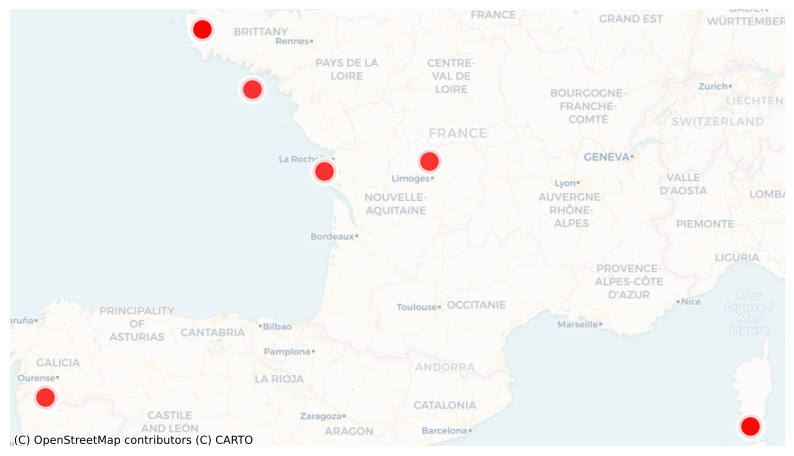

In [11]:
import contextily as cx

CRS_PROJ = "epsg:3857"

gdf.to_crs(CRS_PROJ, inplace=True)
ax = gdf.plot(
    figsize=(10, 15),
    alpha=0.8,
    linewidth=4,
    edgecolor="white",
    facecolor="red",
    markersize=300)
cx.add_basemap(
    ax, alpha=0.5,
    source=cx.providers.CartoDB.Voyager)
# turn of axes display
ax.set_axis_off()

## Prepare query for saxony

The remaining task is simply to turn this test code into a coherent method that loops through the API and saves the results as a CSV for further processing.
We have done this below. There are a few points to highlight:
- each query can return a maximum of `300` results
- the total number of results for unauthenticated queries is `100,000`. In addition, it is recommended to use other access methods, such as the GBIF asynchronous download service.
- We limit our query to the geospatial bounding box for Saxony
- We use CSV to store intermediate data because it is the most accessible and portable data format. Feel free to use other data types, such as [Python DataFrame pickles](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_pickle.html)

```{admonition} How do we know the API limits?
:class: dropdown, tip
We found this out by looking at [the gbif API docs](https://techdocs.gbif.org/en/openapi/v1/occurrence#/Searching%20occurrences).
```

However, before we can start, we need to prepare the spatial parameter to limit results to Saxony. The occurrence search endpoint has a parameter called `geometry` that accepts a Well-Known Text geometry format. Below, we will create a bounding box with `4` corners for the state of Saxony.

1. Get the bounding box for the state of Saxony

```{admonition} Select a different state!
:class: dropdown, attention
Optionally, replace "Sachsen" in the query below with another state in Germany.
```

- we first load a method that we stored for reusability in `py/modules/tools.py`

In [12]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import tools

- Load world countries geometry from the [Bundesamt für Kartographie und Geodäsie (BKG)](https://daten.gdz.bkg.bund.de/produkte/vg/vg2500/aktuell/)

In [13]:
WORK_DIR = Path.cwd().parents[0] / "tmp"    # Working directory
WORK_DIR.mkdir(exist_ok=True)               # Create if not exists
de_shapes = tools.get_shapes(
    "de", shape_dir=WORK_DIR / "shapes")    # Load World geometry
de_shapes.to_crs(CRS_PROJ, inplace=True)    # Project to Web Mercator
sachsen = de_shapes[
    de_shapes.index == "Sachsen"]           # select shape for Sachsen (Saxony)

Already exists


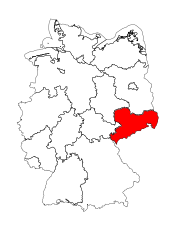

In [14]:
plt_kwags = {
    "color":'none',
    "edgecolor":'black',
    "linewidth":0.2,
    "figsize":(2, 4),
}
ax = de_shapes.plot(**plt_kwags)
plt_kwags["color"] = "red"
ax = sachsen.plot(ax=ax,**plt_kwags)
ax.set_axis_off()

- Get the Bounding Box from the shape of Saxony.
    - We first project to WGS1984 (`epsg:4326`), because we need the bounding box as Decimal Degrees, to be used in the API query
    - We use the [`.bounds` property of the GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html)
    - and then return individual coordinates with the [`.values` property](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.values.html)
    - the [`.squeeze()` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.squeeze.html#pandas.DataFrame.squeeze) reduces the array dimensions; in other words, it produces a simple list so we can access the 4 corners of the bounding box more easily.

(content:references:glue-example)=

In [15]:
bbox_sachsen = sachsen.to_crs("epsg:4326").bounds.values.squeeze()
minx, miny = bbox_sachsen[0], bbox_sachsen[1]
maxx, maxy = bbox_sachsen[2], bbox_sachsen[3]

In [16]:
from IPython.display import Markdown
from myst_nb import glue
bounds_before = sachsen.to_crs("epsg:4326").bounds.values
glue("bounds_before", Markdown(
    f"""
    {bounds_before}
    """))
bounds_after = bbox_sachsen
glue("bounds_after", Markdown(
    f"""
     {bounds_after}
    """))


    [[11.87230817 50.17154199 15.03774334 51.6831409 ]]
    


     [11.87230817 50.17154199 15.03774334 51.6831409 ]
    

````{admonition} Inspect & compare values
:class: dropdown, tip
It is easy to inspect values in Jupyter to better understand value and format transformations.

This is `sachsen.bounds.values`:

```{glue:md} bounds_before
:format: myst
```

.. and this is the result after `squeeze()` was applied:

```{glue:md} bounds_after
:format: myst
```

````

Turn into a Polygon with four corners (Well-Known Text). The GBIF docs also say that the polygon must be ordered in a specific way.

> Polygons must have anticlockwise ordering of points. (A clockwise polygon represents the opposite area: the Earth's surface with a 'hole' in it. Such queries are not supported.)

In [17]:
import shapely
from shapely.geometry import Polygon
from shapely.wkt import dumps

# Create a polygon from the bounding box coordinates
polygon = Polygon([
    (minx, miny),  # Bottom-left
    (minx, maxy),  # Top-left
    (maxx, maxy),  # Top-right
    (maxx, miny),  # Bottom-right
    (minx, miny)   # Close the polygon
])

# Convert the polygon to WKT format
polygon_ordered = shapely.geometry.polygon.orient(Polygon(polygon), 1.0)
polygon_wkt = dumps(polygon_ordered)

print("Polygon WKT:", polygon_wkt)

Polygon WKT: POLYGON ((11.8723081681852403 50.1715419912565537, 15.0377433372033398 50.1715419912565537, 15.0377433372033398 51.6831409000992821, 11.8723081681852403 51.6831409000992821, 11.8723081681852403 50.1715419912565537))


````{admonition} Simpler?
:class: dropdown, tip
There are easier ways to create the Well-Known Text
- There is the [GeoDataFrame.to_wkt()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_wkt.html) which we could have used.
- We could also have simply looked up the bounding box for Saxony using (e.g.) [bboxfinder.com](http://bboxfinder.com/#50.324633,12.101440,51.237875,15.295715).
- We could also have used the original Shape of Saxony (and not its bounding box), to query the API. However, complex polygons increase query time, which is why we did not use the original border of Saxony.

The motivation to calculate the bounding box within the notebook from existing data from the BKG is to fully _parametrize_ the data retrieval. In other words, this notebook can be transferred to other people and used for other regions. To query a different state, you would only need to specify `FOCUS_STATE="Brandenburg"` as a notebook parameter, which will then be honored in the following cells.
````

The last step is to write a method to request data in _chunks_ from the API. We first write down our parameters as a dictionary, including the bounding box from above.

In [18]:
query_url = "https://api.gbif.org/v1/occurrence/search"
limit = 300
params = {
    "taxon_key":taxon_key,
    "continent":continent,
    "limit":limit,
    "geometry":polygon_wkt,
    "offset":0,
    }

In [19]:
response = requests.get(
        url=query_url, params=params)
print(response.url)
response.status_code

https://api.gbif.org/v1/occurrence/search?taxon_key=5231190&continent=europe&limit=300&geometry=POLYGON+%28%2811.8723081681852403+50.1715419912565537%2C+15.0377433372033398+50.1715419912565537%2C+15.0377433372033398+51.6831409000992821%2C+11.8723081681852403+51.6831409000992821%2C+11.8723081681852403+50.1715419912565537%29%29&offset=0


200

In [20]:
from IPython.display import display, Markdown
map_url = 'https://www.gbif.org/occurrence/map'
r = requests.Request('GET', map_url, params=params)
pr = r.prepare()

In [21]:
display(Markdown(f"Test the above API query in your browser by clicking on it. You can also preview [the query on a map]({pr.url})".))

Test the above API query in your browser by clicking on it. You can also preview [the query on a map](https://www.gbif.org/occurrence/map?taxon_key=5231190&continent=europe&limit=300&geometry=POLYGON+%28%2811.8723081681852403+50.1715419912565537%2C+15.0377433372033398+50.1715419912565537%2C+15.0377433372033398+51.6831409000992821%2C+11.8723081681852403+51.6831409000992821%2C+11.8723081681852403+50.1715419912565537%29%29&offset=0)

In [60]:
import pandas as pd

def query_gbif_occurrences(query_url, params):
    """Perform an API call and attach results to dataframe
    
    Steps:
    1. Request occurrences
    2. Raise an error for bad responses
    3. Parse the JSON response
    4. Convert API response to a DataFrame
    5. Show progress
    """
    response = requests.get(
        url=query_url, params=params)               # 1.
    response.raise_for_status()                     # 2.
    data = response.json()                          # 3.
    df = pd.DataFrame.from_dict(data['results'])    # 4.
    clear_output(wait=True)                         # 5.
    display(HTML(
            f"Queried {params.get('offset')} occurrences, "
            f"<a href='{response.url}'>last query-url</a>."))
    return df, data['endOfRecords']

Start the query. We know there is an upper limit of 100,000 occurrences returned by the API, which we use as a base for defining the for.. query below.

In [27]:
%%time
from IPython.display import clear_output, HTML

df = pd.DataFrame()
status = 200

base_path = Path.cwd().parents[0] # one level up from notebooks/ folder
OUTPUT = base_path / "out"
cache_file = OUTPUT / "occurrences_query.csv"

for ix in range(int(100000/limit)):
    if cache_file.exists():
        # do not query again if already queried;
        # load cache instead
        df = pd.read_csv(cache_file)
        break
    params["offset"] = ix*limit
    new_df, end_of_records = query_gbif_occurrences(
        query_url, params)
    df = pd.concat(
        [df, new_df], axis = 0, ignore_index = True, sort = True)
    if end_of_records:
        # exit when all available occurrences have been retrieved
        break

CPU times: user 1.8 s, sys: 264 ms, total: 2.07 s
Wall time: 3min 31s


Cache results as CSV.

:::{tip}
This is generally a good idea, both to conserve limited API resources and to develop code faster (you don't need to query results over and over).
:::

In [28]:
if not cache_file.exists():
    df.to_csv(cache_file)

In [29]:
df.head()

,acceptedScientificName,acceptedTaxonKey,basisOfRecord,behavior,catalogNumber,class,classKey,collectionCode,collectionID,collectionKey,...,taxonRank,taxonomicStatus,type,verbatimCoordinateSystem,verbatimElevation,verbatimEventDate,verbatimIdentification,verbatimLocality,vernacularName,year
0,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,256995752,Aves,212,Observations,NaN,NaN,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/01 09:48,NaN,"01 Dresden-Plauen, Deutschland",NaN,2025.0
1,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,256995753,Aves,212,Observations,NaN,NaN,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/01 09:48,NaN,"01 Dresden-Plauen, Deutschland",NaN,2025.0
2,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,257355151,Aves,212,Observations,NaN,NaN,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/04 3:12 PM,NaN,"06237 Leuna-Kötschlitz, Germany",NaN,2025.0
3,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,257355153,Aves,212,Observations,NaN,NaN,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/04 3:07 PM,NaN,"06237 Leuna-Kötschlitz, Germany",NaN,2025.0
4,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,257355156,Aves,212,Observations,NaN,NaN,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/04 2:57 PM,NaN,"06237 Leuna-Kötschlitz, Germany",NaN,2025.0


After storing results, we rename columns and drop all except `lat` and `lng`, to create a preview map.

In [30]:
df.rename(
    columns={"decimalLatitude": "lat", "decimalLongitude": "lng"},
    inplace=True)
df = df.filter(items=['lat', 'lng'])

In [31]:
gdf = gp.GeoDataFrame(
    df, geometry=gp.points_from_xy(df.lng, df.lat))

Show all occurrences on one map. We use [Geoviews](https://github.com/holoviz/geoviews), which allows us to combine multiple spatial data sources as individual layers on a map. We also add `EsriImagery`, a public satellite tile layer, as background imagery.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
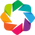

In [56]:
import geoviews as gv
import holoviews as hv
from cartopy import crs as ccrs
hv.notebook_extension('bokeh')

occurrence_layer = gv.Points(df, kdims=['lng', 'lat'])
sachsen_layer = gv.Polygons(
    sachsen.to_crs("epsg:3857"), crs=ccrs.GOOGLE_MERCATOR)

gv_layers = hv.Overlay(
    gv.tile_sources.EsriImagery * \
    sachsen_layer.opts(
        line_color='white',
        line_width=1.0,
        fill_color=None) * \
    occurrence_layer.opts(
        size=3,
        line_color='white',
        line_width=0.1,
        fill_alpha=0.8,
        fill_color='white'))


Once we have prepared the Geoviews `layers` as an _Overlay_, the map is plotted inside the notebook. There are some tweaks below:
- activate the zoom tool by scrollwheel as a default
- zoom in to Saxony and the data bounds
- make sure we use the correct Projection (Web Mercator)
- add a title

In [57]:
def set_active_tool(plot, element):
    """Enable wheel_zoom in bokeh plot by default"""
    plot.state.toolbar.active_scroll = plot.state.tools[0]

bbox_sachsen = sachsen.to_crs("epsg:3857").bounds.values.squeeze()
minx, miny = bbox_sachsen[0], bbox_sachsen[1]
maxx, maxy = bbox_sachsen[2], bbox_sachsen[3]

title = f"Taxon key {taxon_key} (Sparrows) " \
        f"in Saxony with {len(df):,} observations (Gbif API)"

layer_options = {
    "projection":ccrs.GOOGLE_MERCATOR,
    "title": title,
    "responsive":True,        # responsive resize
    "xlim":(minx, maxx),      # limit map boundary to Saxony
    "ylim":(miny, maxy),
    "data_aspect":1.0,        # maintain fixed aspect ratio
    "hooks":[set_active_tool] # enable zoom on scroll wheel by default
}

In [58]:
gv_layers.opts(**layer_options)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]
   .Points.I   :Points   [lng,lat]

Also, it is possible to save this interactive map as a separate standalone HTML (e.g. for archiving purposes or sharing with others). You can view the final map from this step <a href="/geoviews_map.html" title="View the interactive map">here</a>.

In [59]:
layer_options["data_aspect"] = None
hv.save(
    gv_layers.opts(**layer_options),
    OUTPUT / f'geoviews_map.html', backend='bokeh')

## Query all observed occurrences

# IÖR-Monitor WCS Query

```{figure} ../resources/monitor.webp
:name: monitor-graphic
:figclass: fig-no-shadow

Flächenschema des IÖR-Monitors (Area diagram of the IOER Monitor), [Source](https://www.ioer-monitor.de/methodik/#c239).
```